# CoxTime

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

In [159]:
df_train = pd.read_excel("SimData_Transplant_Ver2.0.xls", index_col = False, header=0)
df_train = df_train[df_train['Age_Tx'] >= 18] 

In [160]:
le = LabelEncoder()
df_train["Gender"] = le.fit_transform(df_train["Gender"])
df_train["Bloodtype"] = le.fit_transform(df_train["Bloodtype"])
df_train["Donor_Bloodtype"] = le.fit_transform(df_train["Donor_Bloodtype"])
df_train["Inpt_attx"] = le.fit_transform(df_train["Inpt_attx"])
df_train["Donor_Sex"] = le.fit_transform(df_train["Donor_Sex"])
df_train["Donor_DCD"] = le.fit_transform(df_train["Donor_DCD"])

In [161]:
df_train

,Gender,Bloodtype,Inpt_attx,Donor_Sex,Donor_Bloodtype,Donor_DCD,Waittime,Age_Tx,Donor_Age,TransplantBMI,Donor_BMI,MELD,MELDNA,Time,Cens
0,1,3,2,1,2,0,1,54.291739,45.379636,24.712049,21.369229,22.939930,22.931727,2019.866962,0
1,1,0,0,1,3,0,157,59.817111,60.516200,28.887631,25.408853,18.985337,21.381548,1815.128065,1
2,0,0,0,1,0,0,49,63.198440,30.989861,26.869533,24.902931,23.694392,26.243047,396.556200,0
3,1,3,2,0,2,0,81,28.845900,41.142174,27.411596,35.396950,11.375444,8.545730,1326.259556,0
4,1,3,0,0,3,0,620,55.523918,49.138937,24.530967,29.372668,26.835544,29.211865,605.043515,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,0,0,0,0,0,638,66.768544,62.181956,29.624822,30.205990,17.050266,14.632579,2578.443555,0
3996,1,0,0,1,0,0,146,61.143847,57.131994,24.984602,18.078771,13.369472,10.730959,2642.791337,1
3997,1,0,2,0,0,0,60,41.818547,39.402747,31.146902,24.720377,19.096785,22.031645,3091.405566,0
3998,1,0,0,1,0,0,152,36.732881,18.422351,36.196905,22.702255,16.906836,14.620845,1833.622662,0


In [116]:
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)

In [117]:
X_train = df_train.drop(['Donor_Sex', 'Gender', 'Donor_DCD', 'Donor_BMI', 'Donor_Age'], axis=1)

In [118]:
X_test = df_test.drop(['Donor_Sex', 'Gender', 'Donor_DCD', 'Donor_BMI', 'Donor_Age'], axis=1)

In [119]:
X_train

,Bloodtype,Inpt_attx,Donor_Bloodtype,Waittime,Age_Tx,TransplantBMI,MELD,MELDNA,Time,Cens
3,3,2,2,81,28.845900,27.411596,11.375444,8.545730,1326.259556,0
4,3,0,3,620,55.523918,24.530967,26.835544,29.211865,605.043515,0
5,3,0,3,185,73.722151,27.122416,8.968411,8.964047,3707.852462,0
6,2,2,2,254,44.643404,32.895530,21.318325,24.200950,9.663861,1
7,0,0,0,36,63.126194,28.211870,14.401054,19.627470,1799.694792,0
...,...,...,...,...,...,...,...,...,...,...
3995,0,0,0,638,66.768544,29.624822,17.050266,14.632579,2578.443555,0
3996,0,0,0,146,61.143847,24.984602,13.369472,10.730959,2642.791337,1
3997,0,2,0,60,41.818547,31.146902,19.096785,22.031645,3091.405566,0
3998,0,0,0,152,36.732881,36.196905,16.906836,14.620845,1833.622662,0


In [120]:
cols_standardize = ['Waittime', 'Age_Tx', 'TransplantBMI', 'MELD', 'MELDNA']
cols_leave = ['Bloodtype', 'Inpt_attx', 'Donor_Bloodtype']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [121]:
x_train = x_mapper.fit_transform(X_train).astype('float32')
x_test = x_mapper.transform(X_test).astype('float32')

In [122]:
x_train

array([[-0.3787414 , -2.1239154 , -0.02199114, ...,  3.        ,
         2.        ,  2.        ],
       [ 2.258396  ,  0.3331471 , -0.54494   , ...,  3.        ,
         0.        ,  3.        ],
       [ 0.13009398,  2.009216  , -0.07448881, ...,  3.        ,
         0.        ,  3.        ],
       ...,
       [-0.481487  , -0.92912626,  0.6561157 , ...,  0.        ,
         2.        ,  0.        ],
       [-0.0313634 , -1.3975194 ,  1.5728924 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.09986047, -2.4053862 , -0.79989934, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [123]:
labtrans = CoxTime.label_transform()
get_target = lambda df: (df['Time'].values, df['Cens'].values)
y_train = labtrans.fit_transform(*get_target(X_train))
y_test = labtrans.transform(*get_target(X_test))
Time_test, Cens_test = get_target(X_test)
test = tt.tuplefy(x_test, y_test)

In [124]:
test.shapes()

((800, 8), ((800,), (800,)))

In [125]:
x_train[0]

array([-0.3787414 , -2.1239154 , -0.02199114, -0.938623  , -1.3328376 ,
        3.        ,  2.        ,  2.        ], dtype=float32)

# Neural net
We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. The net required by CoxTime is slightly different than most of the other methods as it also take time and an additional input argument. We have therefore crated the MLPVanillaCoxTime class that is a suitable version of tt.practical.MLPVanilla. This class also removes the options for setting out_features and output_bias as they should be 1 and False, respectively.

In [126]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

# Training the model
To train the model we need to define an optimizer. You can choose any torch.optim optimizer, but here we instead use one from tt.optim as it has some added functionality. We use the Adam optimizer, but instead of choosing a learning rate, we will use the scheme proposed by Smith 2017 to find a suitable learning rate with model.lr_finder. See this post for an explanation.

We also set labtrans which connects the output nodes of the network the the label transform of the durations. This is only useful for prediction and does not affect the training procedure.

In [127]:
model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)

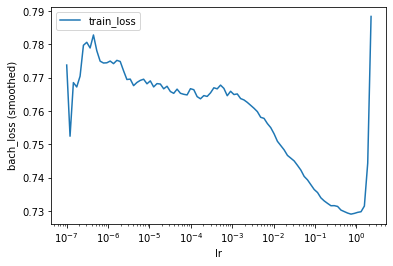

In [128]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [129]:
lrfinder.get_best_lr()

0.07390722033525823

The learning rate is high in general case, so we decrease it to 0.01

In [130]:
model.optimizer.set_lr(0.01)

In [131]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [132]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=test.repeat(10).cat())

0:	[0s / 0s],		train_loss: 0.7559,	val_loss: 0.6987
1:	[0s / 0s],		train_loss: 0.7073,	val_loss: 0.6909
2:	[0s / 0s],		train_loss: 0.6882,	val_loss: 0.7027
3:	[0s / 0s],		train_loss: 0.6962,	val_loss: 0.6983
4:	[0s / 0s],		train_loss: 0.6762,	val_loss: 0.7108
5:	[0s / 0s],		train_loss: 0.6799,	val_loss: 0.7211
6:	[0s / 0s],		train_loss: 0.6709,	val_loss: 0.7123
7:	[0s / 0s],		train_loss: 0.6768,	val_loss: 0.7139
8:	[0s / 0s],		train_loss: 0.6747,	val_loss: 0.7010
9:	[0s / 0s],		train_loss: 0.6783,	val_loss: 0.6932
10:	[0s / 0s],		train_loss: 0.6729,	val_loss: 0.6948
11:	[0s / 0s],		train_loss: 0.6728,	val_loss: 0.6967
Wall time: 466 ms


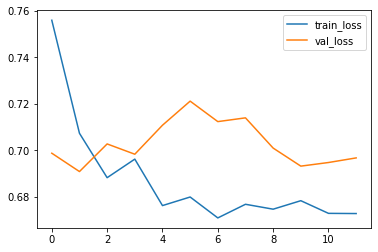

In [133]:
_ = log.plot()

In [135]:
model.partial_log_likelihood(*test).mean()

-5.739084243774414

# Prediction
For evaluation we first need to obtain survival estimates for the test set. This can be done with model.predict_surv which returns an array of survival estimates, or with model.predict_surv_df which returns the survival estimates as a dataframe.

However, as Cox-Time is semi-parametric, we first need to get the non-parametric baseline hazard estimates with compute_baseline_hazards.

Note that for large datasets the sample argument can be used to estimate the baseline hazard on a subset.

In [136]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)

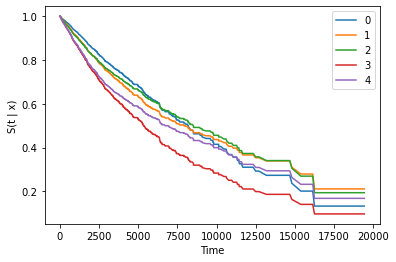

In [137]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

# Evaluation
We can use the EvalSurv class for evaluation the concordance, brier score and binomial log-likelihood. Setting censor_surv='km' means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [147]:
ev = EvalSurv(surv, Time_test, Cens_test, censor_surv='km')

In [148]:
ev.concordance_td()

0.5475040499190016

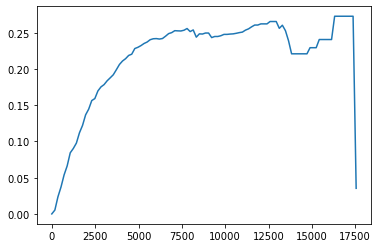

In [150]:
time_grid = np.linspace(Time_test.min(), Time_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In terms of benchmarks, a useful model will have a Brier score below 
0.25

In [151]:
ev.integrated_brier_score(time_grid) #brier_score

0.21770172730282067

In [152]:
ev.integrated_nbll(time_grid) #binomial log-likelihood

0.6184905717194111

In [154]:
surv.iloc[:, :5]

,0,1,2,3,4
0.491054,1.000000,1.000000,1.000000,1.000000,1.000000
0.494233,1.000000,1.000000,1.000000,1.000000,1.000000
0.868685,1.000000,1.000000,1.000000,1.000000,1.000000
0.933551,1.000000,1.000000,1.000000,1.000000,1.000000
2.752196,0.999779,0.999699,0.999665,0.999547,0.999555
...,...,...,...,...,...
16001.578398,0.201154,0.279154,0.269403,0.140433,0.232190
16130.963762,0.201154,0.279154,0.269403,0.140433,0.232190
16241.729479,0.132682,0.211186,0.193793,0.096867,0.167980
17482.899965,0.132682,0.211186,0.193793,0.096867,0.167980
